# Assignment 12
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


### In this Assignment we are going to implement CIFAR10 model using the reference code given for the assignment and also we will try to impliment OneCycleLR. For this puspose we are going to use model architecture as the best Session 6 model architecture.

### So to achieve this goal lets first import keras library and  import all pakages and functions from keras with which we are going to build the CNN model

In [142]:
!git clone https://github.com/santuhazra1/keras-one-cycle.git /tmp/keras_one_cycle
!mv /tmp/keras_one_cycle/clr.py clr.py 
!rm -r /tmp/keras_one_cycle
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.preprocessing import image
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
import cv2

from clr import LRFinder, OneCycleLR

Cloning into '/tmp/keras_one_cycle'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 211 (delta 0), reused 0 (delta 0), pack-reused 208
Receiving objects: 100% (211/211), 3.19 MiB | 2.46 MiB/s, done.
Resolving deltas: 100% (82/82), done.


### Now we are going to load the pre-shuffled CIFAR10 data from keras. Out of total 60k data we have 50k different class image as train data and 10k image as test data which is autometically predefined in mnist dataset. So here we have total 10 different classes of images as: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

In [126]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
print(train_features.shape)
print(test_features.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Now let's look into some images. Here we are going to pick one image from each class randomly to see how it looks:

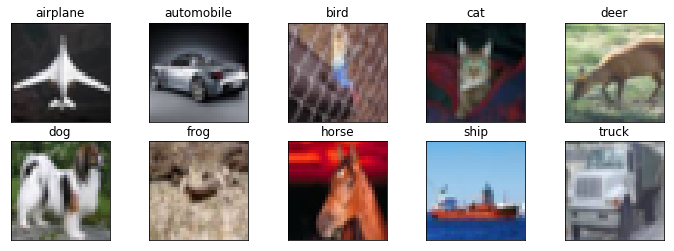

In [127]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(12,4))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Now here we are going to create a function which is going to plot our train and test model accuracy and losses with respect epochs.

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### Also, here we have created one more function which is going to give us actual  test accuracy from model and test data:

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Now let's create a Random Crop function for image augmentation:

In [0]:
def RandomCrop(img,crop_size,padding=None):
  if padding==None:
    img
  else:
    img = np.pad(img,((padding,padding),(padding,padding),(0,0)), mode='constant')
    
  height, width = img.shape[0], img.shape[1]
  dy, dx = crop_size
  x = np.random.randint(0, width - dx + 1)
  y = np.random.randint(0, height - dy + 1)
  return img[y:(y+dy), x:(x+dx), :]

#x_train = train_features        
train_crops = np.zeros_like(train_features)
for i in range(train_features.shape[0]):
    train_crops[i] = RandomCrop(train_features[i], (32, 32),4)
train_features= train_crops

### Now, lets scale the test and train data and change labels from 1-dimentional class matrix to 10 dimentional class matrix so that we can predict out of 10 class.

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### In the below model we have used batch normalization and learning rate optimization technique and we have also changed the amount of droupout in each layer. Now, let's see how this model is going to perform:

In [133]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(10, 1, 1))

model.add(AveragePooling2D(pool_size = (4,4)))
model.add(Flatten())


model.add(Activation('softmax'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same"

### Now let's look at the model summary:

In [134]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_29 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_30 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 64)        0         
__________

### Now, lets implement cutout augmentation technique in our CFIAR10 dataset and train the model with augmented data:

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

### Now, As we have to implement OneCycleLR for that purpose first we have to find optimum learning rate, momentum and weight decay. So, let's first try to find optimum learning rate through LRFinder:

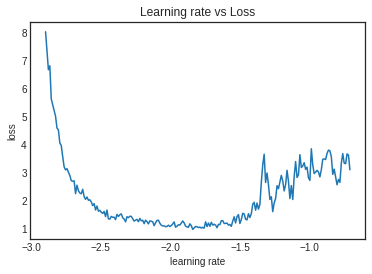

In [0]:
import os
if not os.path.exists('weights/'):
    os.makedirs('weights/')

weights_file = 'weights/LR_schedule.h5'
model_checkpoint = ModelCheckpoint(weights_file, monitor='val_acc', save_best_only=True,
                                   save_weights_only=True, mode='max')
model_LR_Finder = model

mean = np.mean(train_features, axis=(0, 1, 2), keepdims=True).astype('float32')
std = np.mean(train_features, axis=(0, 1, 2), keepdims=True).astype('float32')

X_train = (train_features - mean) / (std)
X_test = (test_features - mean) / (std)

num_samples = X_train.shape[0]
batch_size = 128

lr_finder = LRFinder(num_samples, batch_size, minimum_lr=1e-3, maximum_lr=10.,
                     lr_scale='exp',
                     validation_data=(X_test, test_labels),  # use the validation data for losses
                     validation_sample_rate=5,
                     save_dir='weights/', verbose=0)

optimizer = SGD(lr=0.1, momentum=0.9, nesterov=True)
model_LR_Finder.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_LR_Finder.fit(X_train, train_labels,
          batch_size=batch_size,
          epochs=1,
          validation_data=(X_test, test_labels),
          shuffle=True,
          verbose=0,
          callbacks=[lr_finder, model_checkpoint])

lr_finder.plot_schedule(clip_beginning=10, clip_endding=5)

### From the above curve we can see that after -1.8 loss became unstable and if we further increase learning rate loss is increasing. So, we we can take maximum learning rate as -1.8. Now, since this is in log scale so actual learning rate is going to be 10^-1.8 i.e. 0.015. 

### Next we are going to use this optimim learning rate to find optimum momentum in the below using LRFinder:

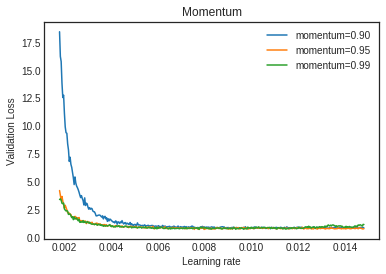

In [0]:
MOMENTUMS = [0.9, 0.95, 0.99]

for momentum in MOMENTUMS:
  lr_finder2 = LRFinder(num_samples, batch_size, minimum_lr=0.0015, maximum_lr=0.015,
                     validation_data=(X_test, test_labels),
                     validation_sample_rate=5,
                     lr_scale='linear', save_dir='weights/momentum/momentum-%s/' % str(momentum),
                     verbose=0)


  model_Momentum = model

  optimizer2 = SGD(lr=0.002, momentum=momentum, nesterov=True)
  model_Momentum.compile(loss='categorical_crossentropy', optimizer=optimizer2, metrics=['accuracy'])

  model_Momentum.fit(X_train, train_labels,
          batch_size=batch_size,
          epochs=1,
          validation_data=(X_test, test_labels),
          shuffle=True,
          verbose=0,
          callbacks=[lr_finder2])



for momentum in MOMENTUMS:
    directory = 'weights/momentum/momentum-%s/' % str(momentum)

    losses, lrs = LRFinder.restore_schedule_from_dir(directory, 10, 5)
    plt.plot(lrs, losses, label='momentum=%0.2f' % momentum)

plt.title("Momentum")
plt.xlabel("Learning rate")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

### So, from the above graph we can see that out 3 momentum yellow curve corrosponding to 0.95 is performing better overall. So, in this case we are going to take our optimim momentum as 0.95


### Now let's try to define some hyper parameter which we are going to use later on.

In [0]:
BATCH_SIZE = 512 #@param ["512", "256", "128", "64"] {type:"raw"}
MOMENTUM = 0.95 #@param ["0.9", "0.95", "0.975"] {type:"raw"}
WEIGHT_DECAY = 0.000125 #@param ["0.000125","1e-7", "3e-7", "3e-6", "5e-4"] {type:"raw"}
LEARNING_RATE = 0.015 #@param ["0.4", "0.2", "0.1", 0.015] {type:"raw"}
EPOCHS = 100 #@param {type:"slider", min:0, max:300, step:1}


### Now, Let's implement One Cycle CLR using maximum learning rate and momentum:

In [0]:
lr_manager_model = OneCycleLR(num_samples = train_features.shape[0], batchsize= BATCH_SIZE, max_lr=LEARNING_RATE,
                        end_percentage=0.1, scale_percentage=None,
                        maximum_momentum=MOMENTUM, minimum_momentum=MOMENTUM)

### Now we are going to run this model for 100 epochs and let's check what training accuracy we are going to get:

In [0]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True), metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_s

Class: <clr.OneCycleLR object at 0x7f8a948deb38>
Values: {'validation_data': None, 'model': <keras.engine.sequential.Sequential object at 0x7f8a95762358>, 'initial_lr': 0.015, 'end_percentage': 0.1, 'scale': 0.1, 'max_momentum': 0.95, 'min_momentum': 0.95, 'verbose': True, '_update_momentum': True, 'clr_iterations': 0.0, 'history': {}, 'epochs': None, 'batch_size': 512, 'samples': 50000, 'steps': None, 'num_iterations': None, 'mid_cycle_id': None, 'params': {'epochs': 100, 'steps': 97, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}}
Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 3/97 [..............................] - ETA: 1:08 - loss: 3.5004 - acc: 0.1048

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.220828). Check your callbacks.
  % delta_t_median)


97/97 [==============================] - 21s 220ms/step - loss: 2.0937 - acc: 0.2738 - val_loss: 1.7902 - val_acc: 0.3679

Epoch 00001: val_acc improved from -inf to 0.36790, saving model to best_model.hdf5
 - lr: 0.00179 - momentum: 0.95 
Epoch 2/100
97/97 [==============================] - 19s 200ms/step - loss: 1.6625 - acc: 0.4034 - val_loss: 2.0774 - val_acc: 0.3694

Epoch 00002: val_acc improved from 0.36790 to 0.36940, saving model to best_model.hdf5
 - lr: 0.00209 - momentum: 0.95 
Epoch 3/100
97/97 [==============================] - 19s 199ms/step - loss: 1.4941 - acc: 0.4745 - val_loss: 1.5039 - val_acc: 0.5140

Epoch 00003: val_acc improved from 0.36940 to 0.51400, saving model to best_model.hdf5
 - lr: 0.00238 - momentum: 0.95 
Epoch 4/100
97/97 [==============================] - 19s 199ms/step - loss: 1.3760 - acc: 0.5188 - val_loss: 1.2976 - val_acc: 0.5642

Epoch 00004: val_acc improved from 0.51400 to 0.56420, saving model to best_model.hdf5
 - lr: 0.00268 - momentum: 0

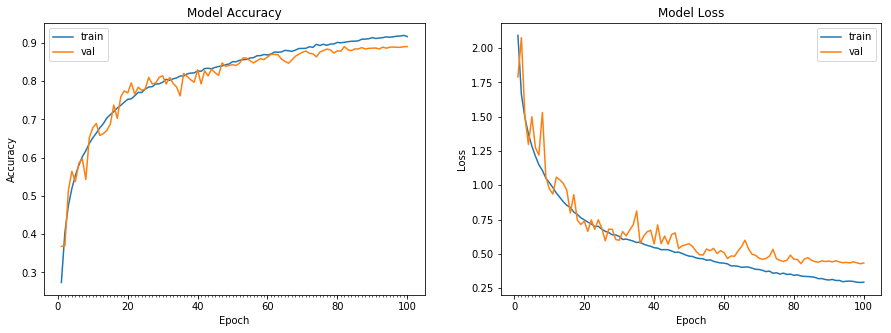

Accuracy on test data is: 89.01


In [140]:
# checkpoint
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(zoom_range=0.0,horizontal_flip=True,
                             featurewise_center=True, featurewise_std_normalization=True,preprocessing_function=get_random_eraser(v_l=0, v_h=1,pixel_level=True))

datagen_test = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
iterator_test = datagen_test.flow(test_features, test_labels, batch_size=len(test_features), shuffle=False)
test_features_2, test_labels_2 = iterator_test.next()

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen_train.flow(train_features, train_labels, batch_size = BATCH_SIZE),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = EPOCHS, 
                                 validation_data = (test_features_2, test_labels_2), verbose=1,
                                 callbacks=[checkpoint,lr_manager_model])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
model.load_weights('best_model.hdf5')
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

### From the above we can see we have reached maximum validation accuracy of 89.01%